In [1]:
import pandas as pd
import numpy as py

In [2]:
! pip install numpy scipy librosa matplotlib


[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


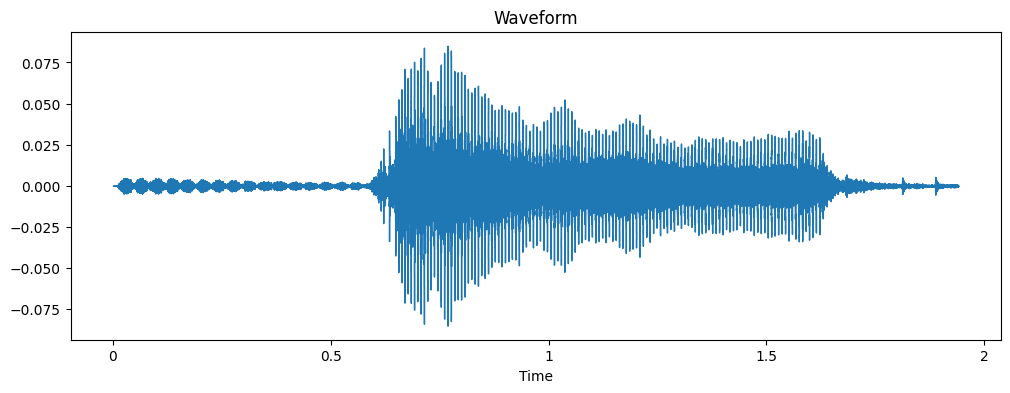

In [3]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the audio file
audio_path = '../data/raw/test.wav'
y, sr = librosa.load(audio_path, sr=None)  # y is the audio time series, sr is the sampling rate

# Display the waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.show()

In [4]:
y_trimmed, _ = librosa.effects.trim(y)

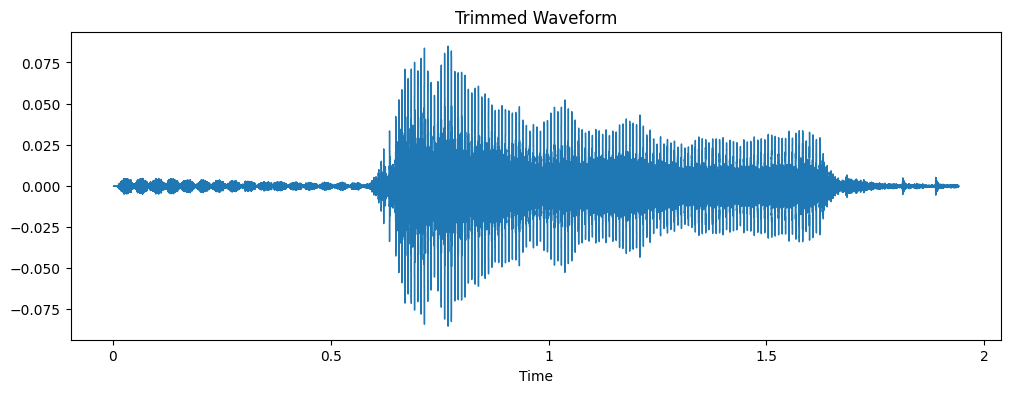

In [5]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y_trimmed, sr=sr)
plt.title('Trimmed Waveform')
plt.show()

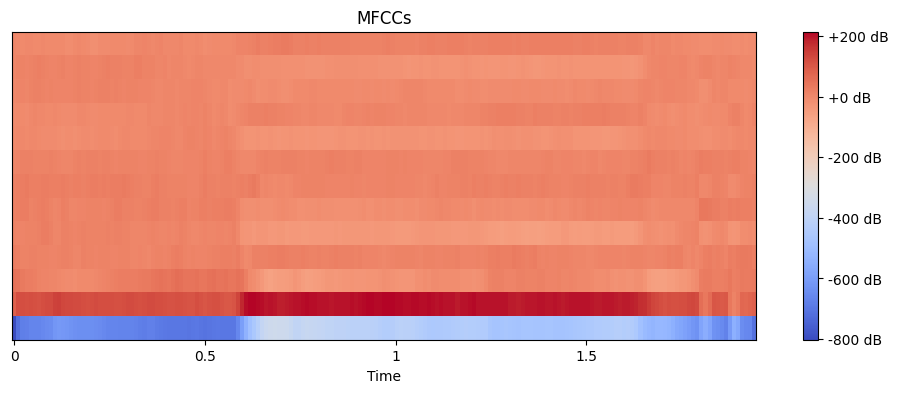

In [6]:
import librosa.display

# Extract MFCCs
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Display the MFCCs
plt.figure(figsize=(12, 4))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCCs')
plt.show()

In [7]:
import numpy as np

# Save MFCCs to a file
np.save('mfccs.npy', mfccs)

# Load the saved MFCCs
mfccs_loaded = np.load('mfccs.npy')

Pitch

In [8]:
f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=50, fmax=300)
f0_mean = np.mean(f0)
f0_max = np.max(f0)
f0_min = np.min(f0)

In [9]:
# Recompute pitch and related features
f0, _, _ = librosa.pyin(y_trimmed, fmin=50, fmax=300)

# Handle NaN values
if np.isnan(f0).all():
    print("No pitch detected in the trimmed audio file.")
    f0_mean = f0_max = f0_min = 0
else:
    f0_mean = np.nanmean(f0)
    f0_max = np.nanmax(f0)
    f0_min = np.nanmin(f0)

Jitter

In [10]:
jitter_percent = np.mean(np.abs(np.diff(f0)) / f0[:-1]) * 100
jitter_abs = np.mean(np.abs(np.diff(f0)))
rap = np.mean(np.abs(np.diff(f0, n=3)))
ppq = np.mean(np.abs(np.diff(f0, n=5)))
ddp = np.mean(np.abs(np.diff(f0, n=2)))

In [11]:
if f0_mean > 0:
    jitter_percent = np.mean(np.abs(np.diff(f0)) / f0[:-1]) * 100
    jitter_abs = np.mean(np.abs(np.diff(f0)))
    rap = np.mean(np.abs(np.diff(f0, n=3)))
    ppq = np.mean(np.abs(np.diff(f0, n=5)))
    ddp = np.mean(np.abs(np.diff(f0, n=2)))
else:
    jitter_percent = jitter_abs = rap = ppq = ddp = 0

In [12]:
# Remove NaN values from f0
f0_clean = f0[~np.isnan(f0)]

# Check if f0_clean is non-empty and has enough values for jitter calculation
if len(f0_clean) > 1:  # Need at least two values to compute differences
    jitter_percent = np.mean(np.abs(np.diff(f0_clean)) / f0_clean[:-1]) * 100
    jitter_abs = np.mean(np.abs(np.diff(f0_clean)))
    
    # RAP (Relative Average Perturbation) typically uses a window of 3 samples
    if len(f0_clean) >= 3:
        rap = np.mean(np.abs(np.diff(f0_clean, n=3)))
    else:
        rap = 0  # Not enough samples to compute RAP
    
    # PPQ (Pitch Period Perturbation Quotient) typically uses a window of 5 samples
    if len(f0_clean) >= 5:
        ppq = np.mean(np.abs(np.diff(f0_clean, n=5)))
    else:
        ppq = 0  # Not enough samples to compute PPQ
    
    # DDP (Difference of Difference of Periods)
    if len(f0_clean) >= 2:
        ddp = np.mean(np.abs(np.diff(f0_clean, n=2)))
    else:
        ddp = 0  # Not enough samples to compute DDP
else:
    # If f0_clean is empty or has only one value, set jitter-related features to 0 or some default
    jitter_percent = jitter_abs = rap = ppq = ddp = 0

Shimmer

In [13]:
amplitude = np.abs(librosa.stft(y))
shimmer = np.mean(np.abs(np.diff(amplitude)))
shimmer_dB = 20 * np.log10(shimmer)
apq3 = np.mean(np.abs(np.diff(amplitude, n=3)))
apq5 = np.mean(np.abs(np.diff(amplitude, n=5)))
dda = np.mean(np.abs(np.diff(amplitude, n=2)))

NHR, HNR

In [14]:
hnr = librosa.effects.harmonic(y).mean() / np.std(y)
nhr = np.std(y) / librosa.effects.harmonic(y).mean()

In [15]:
features = {
    'F0_Mean': f0_mean,
    'F0_Max': f0_max,
    'F0_Min': f0_min,
    'Jitter_Percent': jitter_percent,
    'Jitter_Abs': jitter_abs,
    'RAP': rap,
    'PPQ': ppq,
    'DDP': ddp,
    'Shimmer': shimmer,
    'Shimmer_dB': shimmer_dB,
    'APQ3': apq3,
    'APQ5': apq5,
    'DDA': dda,
    'HNR': hnr,
    'NHR': nhr
}

In [16]:
df = pd.DataFrame([features])

In [17]:
df.head()

,F0_Mean,F0_Max,F0_Min,Jitter_Percent,Jitter_Abs,RAP,PPQ,DDP,Shimmer,Shimmer_dB,APQ3,APQ5,DDA,HNR,NHR
0,58.446615,65.595405,53.588673,0.637003,0.373639,0.665457,2.174747,0.409729,0.012272,-38.221542,0.02696,0.085877,0.016415,-0.003912,-255.602997
